In [ ]:
# important, you need to install scvelo

import os
import numpy as np
import pandas as pd
import scprep
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import magic
from scipy.stats import spearmanr

In [ ]:
path_cwd=os.getcwd()
path_train_data=path_cwd + '/ML4G_Project_2_Data/train_data'
path_test_data=path_cwd + '/ML4G_Project_2_Data/test_data'

In [140]:
#train_data
bulk_train=pd.read_csv(path_train_data +'/pancreas_bulk_train.csv',index_col=0)
metadata_train=pd.read_csv(path_train_data+ '/pancreas_sc_metadata_train.csv')
metadata_train["Celltype"] = pd.factorize(metadata_train["Celltype"])[0]
sc_train=scprep.io.load_csv(path_train_data +'/pancreas_sc_train.csv', cell_axis='column')

#test_data
metadata_test=pd.read_csv(path_test_data+ '/pancreas_sc_metadata_test_wocelltype.csv')
metadata_test["Disease"] = pd.factorize(metadata_test["Disease"])[0]
sc_test=scprep.io.load_csv(path_test_data +'/pancreas_sc_test.csv', cell_axis='column')

## 0. Preprocessing Methods

In [ ]:
def sc_filter(sc_data, min_cells=10):
    # filter out patient cells with few entries - does not make sense for us
    # sc_data = scprep.filter.filter_library_size(sc_data, cutoff=cutoff)
    
    # Filter all genes with negligible counts in all but a few cells.
    sc_data = scprep.filter.filter_rare_genes(sc_data, min_cells=min_cells)
    return sc_data

In [148]:
# Preprocessing
def sc_preprocess(sc_data, min_cells=0, sq_transform=True, normalize=True):
    # filter out genes with low expression
    sc_data = sc_filter(sc_data, min_cells=min_cells)

    # Normalize library sizes
    if normalize==True:
        sc_data = scprep.normalize.library_size_normalize(sc_data)
        
    # Transform sqrt
    if sq_transform==True:
        sc_data = scprep.transform.sqrt(sc_data)

    return sc_data

## 1. Data Imputation

In [83]:
# Preprocess the data
sc_train_pp = sc_preprocess(sc_train, min_cells=200) # without sc_filter!
sc_train_pp.head(3)

Unnamed: 0,CLIC4,NECAP2,DBT,RFWD2,C1orf21,PRUNE,PRKCZ,PRDM16,C1orf159,CAMTA1,...,TYMP,NCAPH2,SBF1,LMF2,ODF3B,ARSA,MAPK8IP2,CHKB,RABL2B,RPL23AP82
patient1_A10,1.162871,1.220938,0.103188,1.047245,1.686107,0.000000,0.309564,0.0,1.011033,0.956927,...,0.37205,0.00000,0.000000,0.869478,1.125649,0.000000,0.000000,0.472867,0.000000,0.0
patient1_A12,0.000000,0.000000,0.731252,0.000000,0.000000,1.500498,0.000000,0.0,0.000000,0.589156,...,0.00000,1.09152,0.000000,0.000000,0.556399,1.900466,0.780884,0.256259,0.000000,0.0
patient1_A13,0.000000,0.000000,0.920342,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00000,0.00000,0.426036,0.000000,0.000000,1.307358,1.496188,0.388916,0.639053,0.0


In [84]:
# MAGIC
sc_train_magic = magic.MAGIC(n_pca=1000,
                              t='auto',
                                knn=50,
                                decay=1,
                                n_jobs=8,
                                random_state=0,
                                verbose=2
                              ).fit_transform(sc_train_pp)
sc_train_magic.head(3)
sc_train_magic.to_csv('ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv')

Calculating MAGIC...
  Running MAGIC on 978 cells and 10400 genes.
  Calculating graph and diffusion operator...
    Building knn graph
    Initializing [<class 'graphtools.graphs.kNNGraph'>] with arguments bandwidth='None', kernel_symm='+', decay='1', thresh='0.0001', verbose='2', knn_max='150', random_state='0', initialize='True', knn='50', theta='None', n_jobs='8', rank_threshold='None', bandwidth_scale='1.0', n_pca='1000', distance='euclidean', anisotropy='0'
    Initializing kernel...
    Calculating KNN search...
    Calculated KNN search in 8.30 seconds.
    Calculating affinities...
      search_knn = 151; 978 remaining
      knn search to knn_max (151) on 978
    Calculated affinities in 7.16 seconds.
    Using addition symmetrization.
  Calculated graph and diffusion operator in 15.55 seconds.
  Running MAGIC with `solver='exact'` on 10400-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calcu

Unnamed: 0,CLIC4,NECAP2,DBT,RFWD2,C1orf21,PRUNE,PRKCZ,PRDM16,C1orf159,CAMTA1,...,TYMP,NCAPH2,SBF1,LMF2,ODF3B,ARSA,MAPK8IP2,CHKB,RABL2B,RPL23AP82
patient1_A10,0.632217,0.719672,0.282086,0.505840,0.271378,0.453469,0.235938,0.390071,0.245176,0.872783,...,0.560305,0.395428,0.498498,0.898350,0.282272,1.142297,0.123243,0.159594,0.187873,0.130419
patient1_A12,0.138408,0.306393,0.218557,0.269236,0.308175,0.762991,0.133970,0.074602,0.101149,0.841090,...,0.113127,0.315396,0.307153,0.554300,0.121936,1.096985,0.558944,0.165090,0.147071,0.101928
patient1_A13,0.163337,0.334896,0.250524,0.282762,0.254558,0.735786,0.143555,0.078574,0.096995,0.811805,...,0.106861,0.351517,0.330457,0.593717,0.097906,1.093519,0.642383,0.163783,0.151242,0.107995


In [54]:
# remove list of elements from a list
filtered_genes = [gene for gene in sc_train.columns if gene not in sc_train_magic.columns]
filtered_genes_df = pd.DataFrame(0, index=filtered_genes, columns=['genes'])

In [55]:
# add filtered genes to magic dataframe
pred = sc_train_magic.mean(axis=0)
pred = pd.DataFrame(pred, columns=['genes'])
pred_all = pd.concat([pred, filtered_genes_df], axis=0)
pred_all = pred_all.reindex(sc_train.columns)

In [56]:
# check correlation
baseline=spearmanr(sc_train.mean(axis=0),bulk_train.mean(axis=1)).statistic
score=spearmanr(pred_all,bulk_train.mean(axis=1)).statistic
print(f'Correlation before imputation: {baseline}')
print(f'Best Correlation: {score}')

Correlation before imputation: 0.9550851204047768
Best Correlation: 0.9553498562330239


## 2. Clustering - UMAP Visualizations

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

<Axes: >

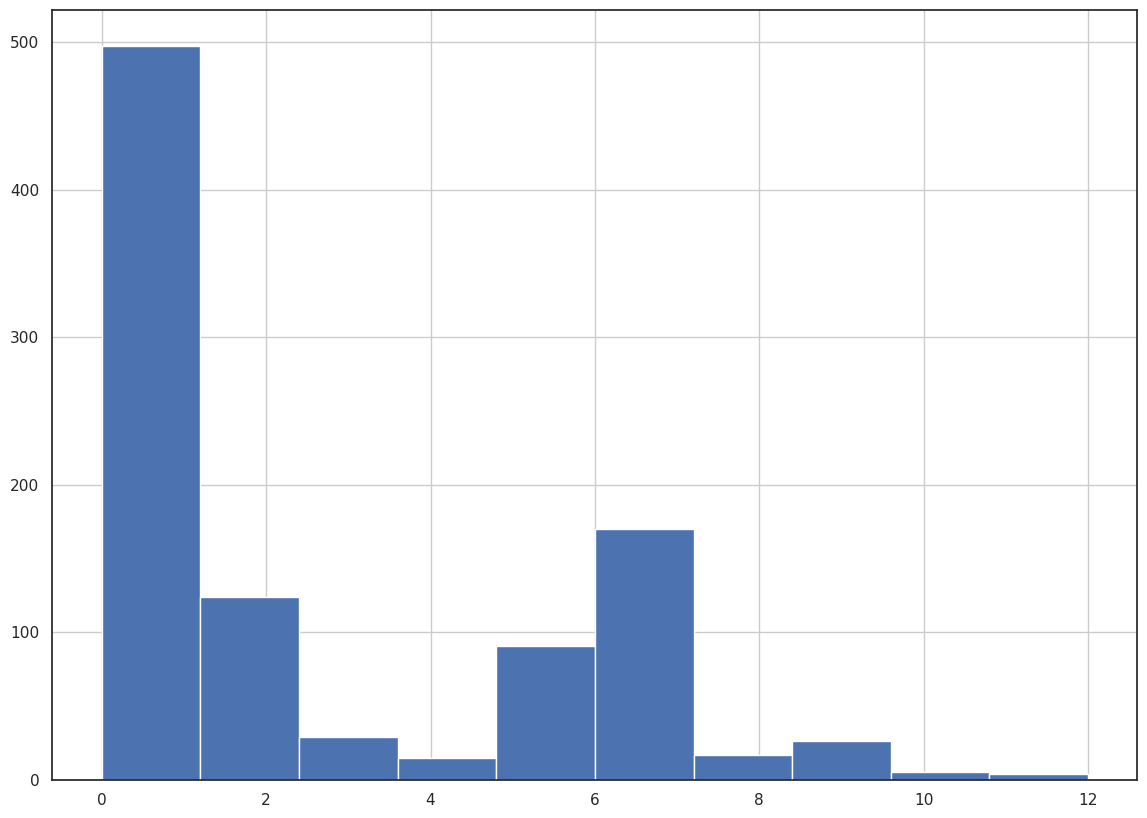

In [ ]:
# Show number of celltypes in training data
metadata_train["Celltype"].hist()

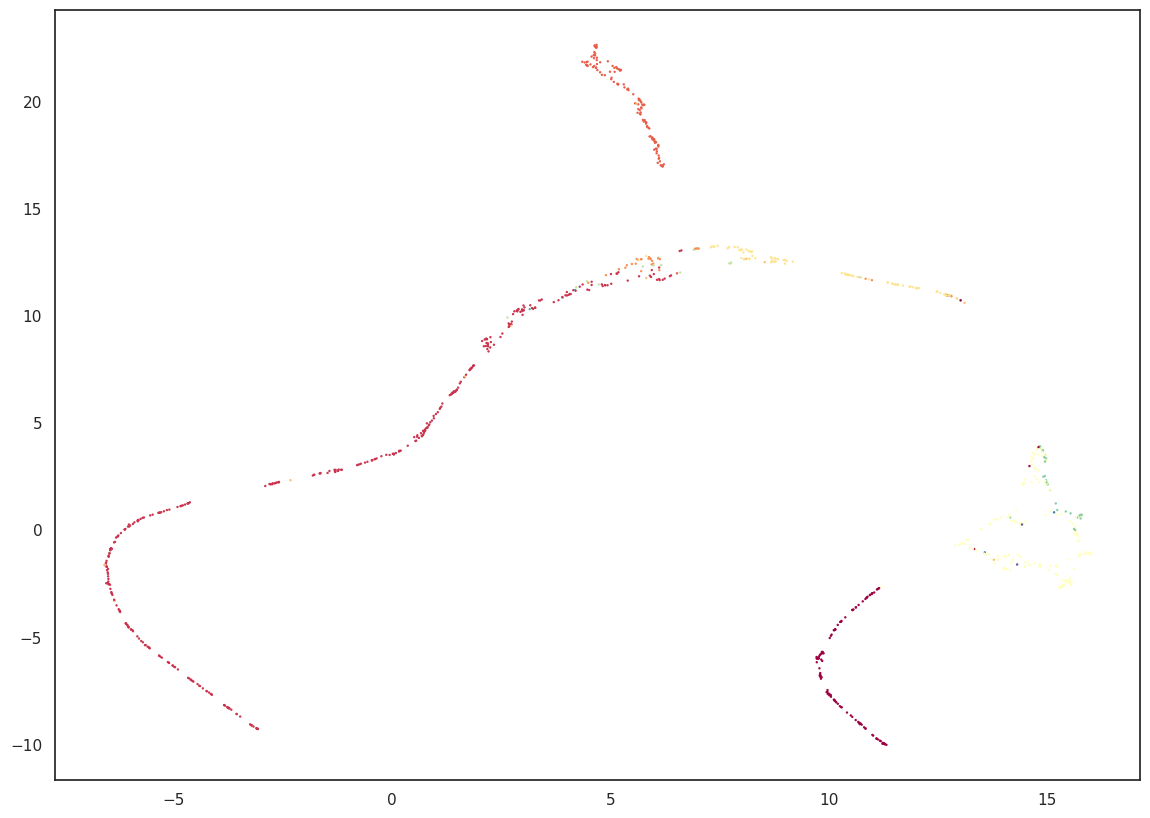

In [86]:
# Imputed data MAGIC - preprocessed
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

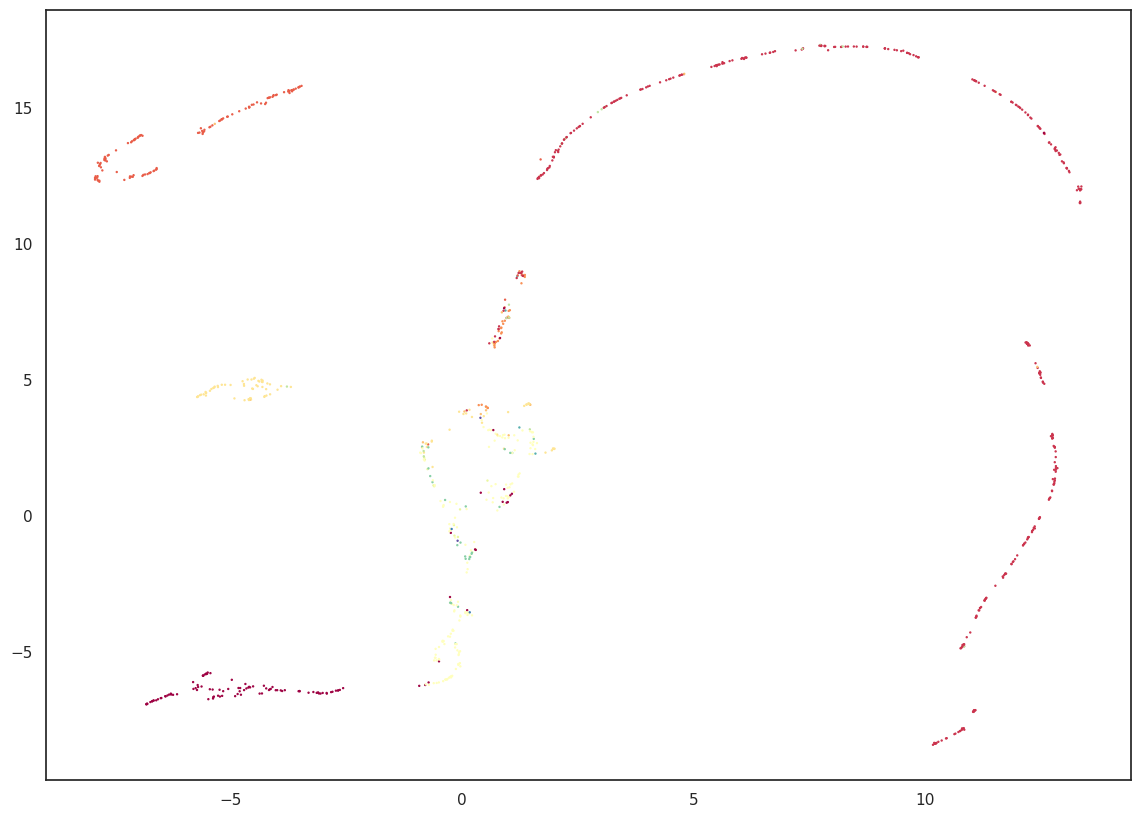

In [61]:
# Imputed data MAGIC
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

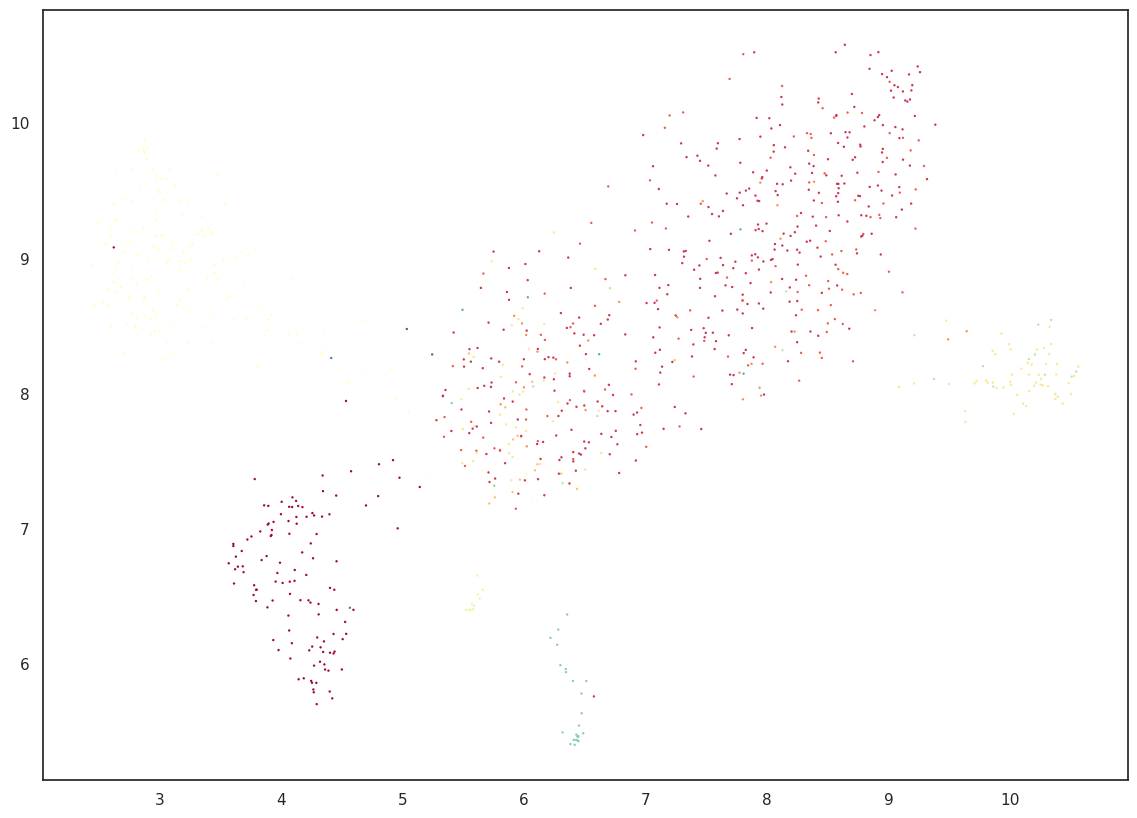

In [89]:
# Imputed data scISR
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_scISR_pp.csv", index_col=0)
imputed_data = sc_preprocess(imputed_data, min_cells=200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data.T)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

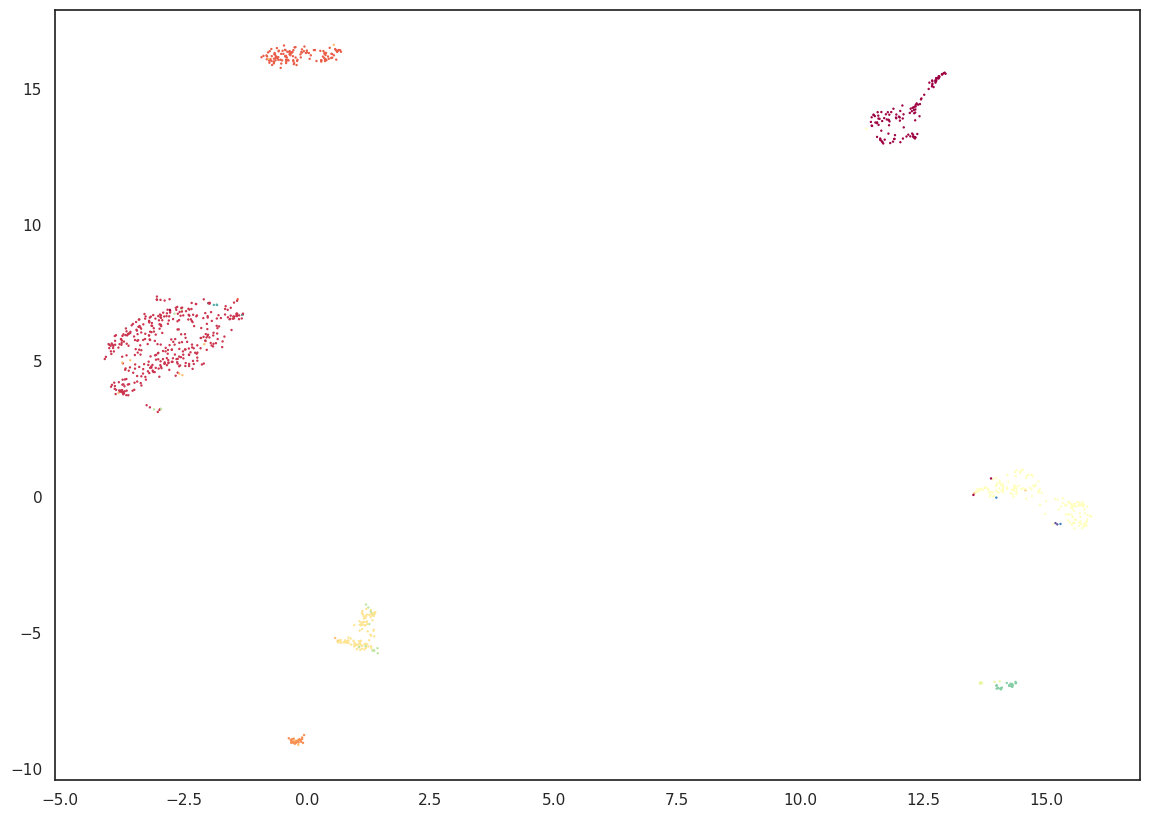

In [149]:
# With preprocessing raw data
sc_train_pp = sc_preprocess(sc_train, 200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

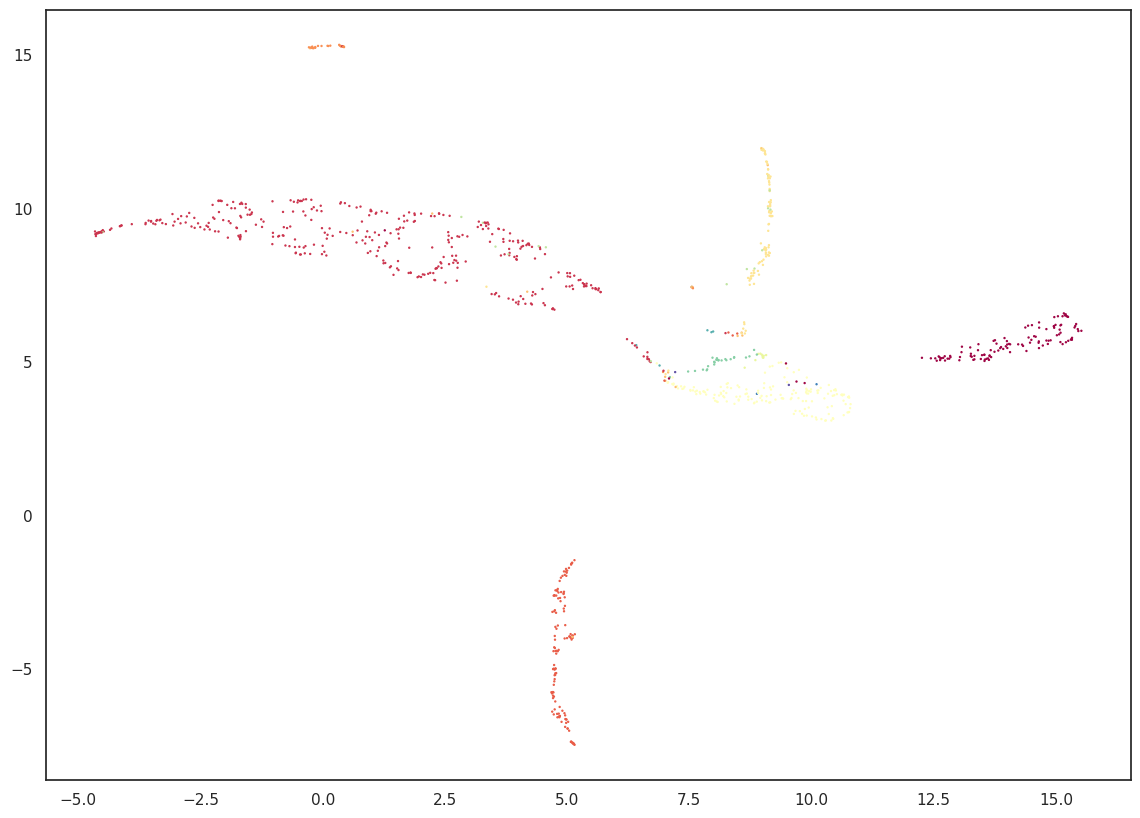

In [150]:
# With preprocessing raw data and without normalization or sqrt transformation
sc_train_pp = sc_preprocess(sc_train, 200, normalize=False, sq_transform=False)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

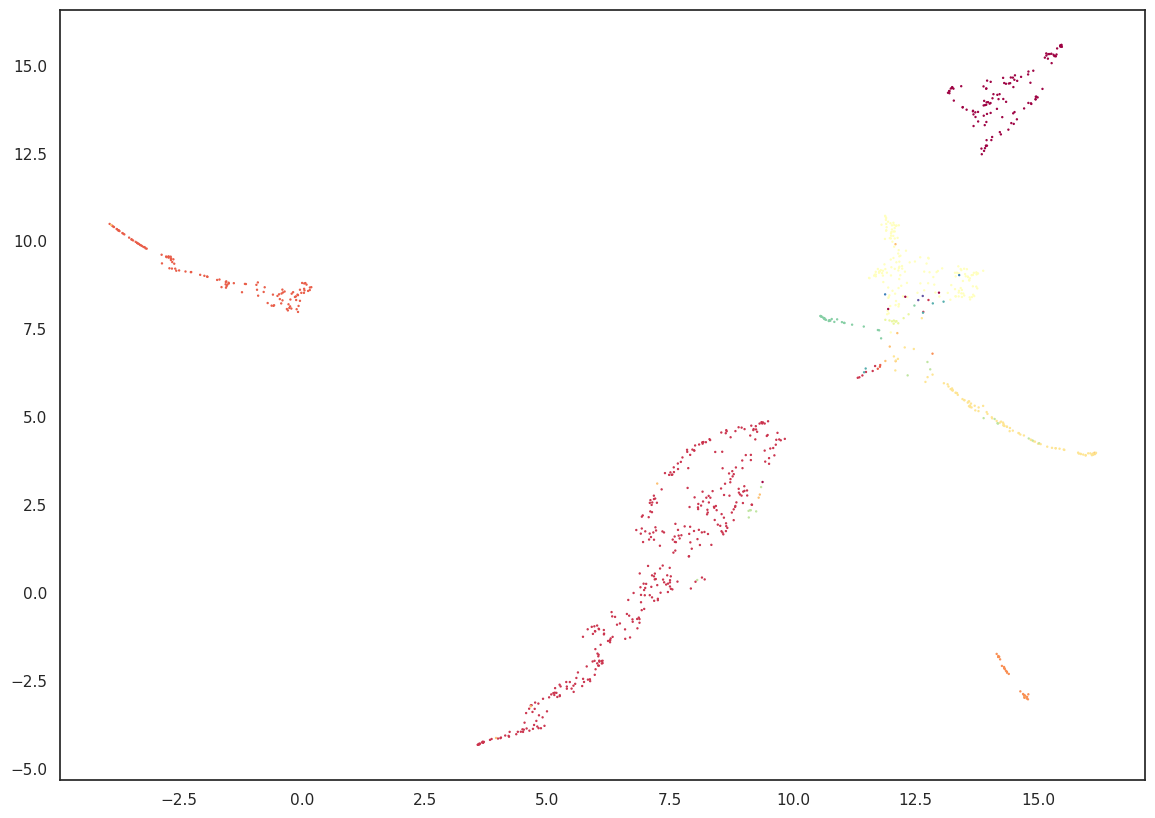

In [151]:
# With preprocessing raw data and without sqrt transformation
sc_train_pp = sc_preprocess(sc_train, 200, normalize=True, sq_transform=False)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

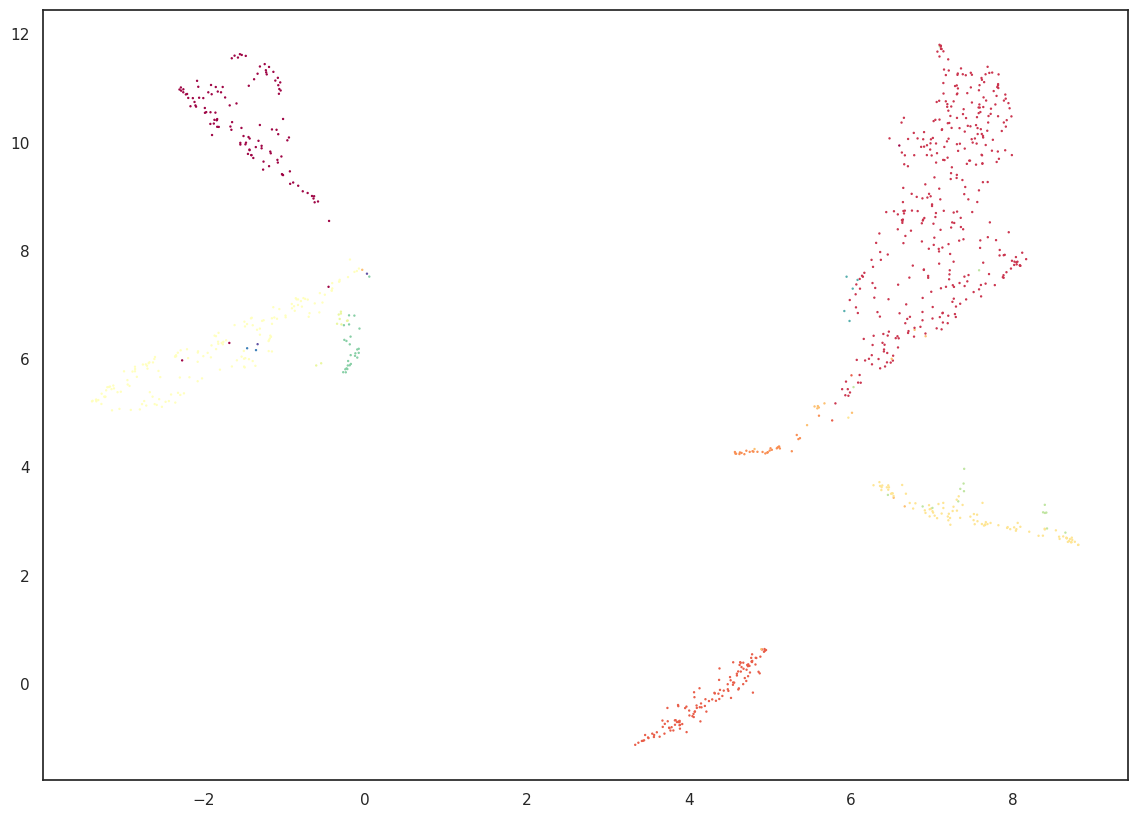

In [152]:
# With preprocessing raw data and without sqrt transformation
sc_train_pp = sc_preprocess(sc_train, 200, normalize=False, sq_transform=True)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

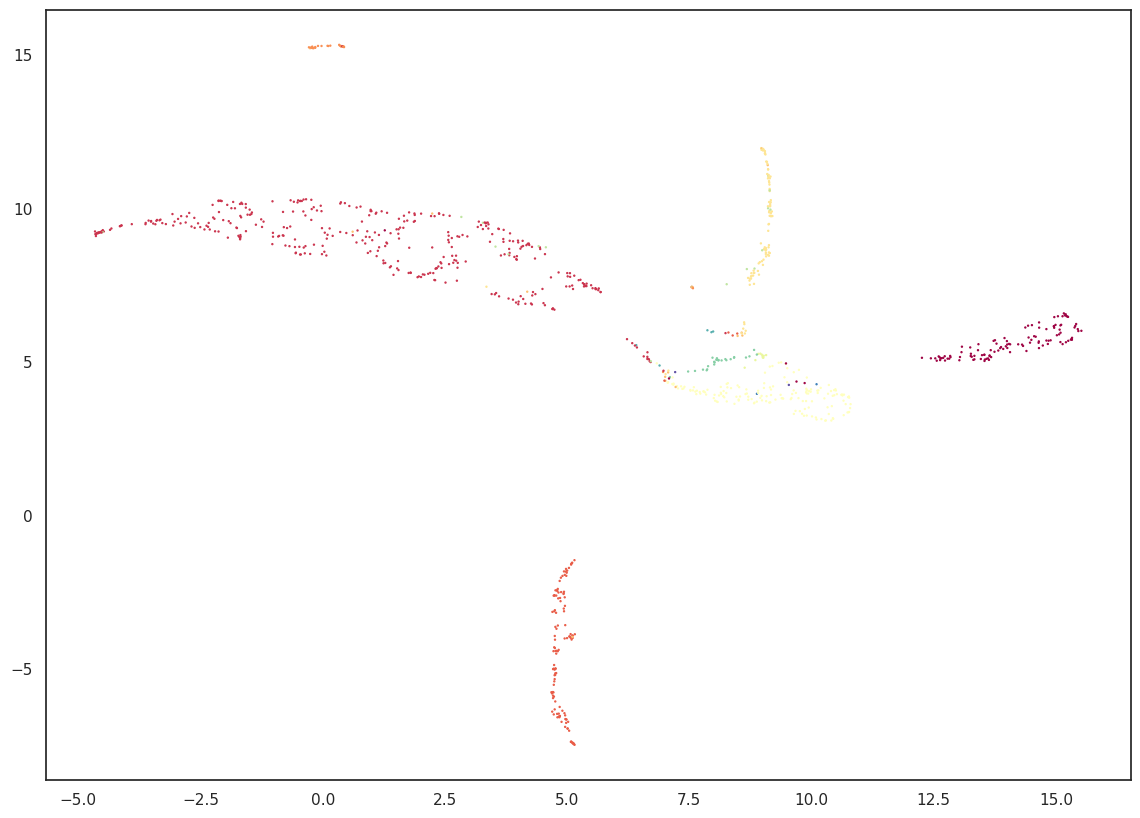

In [153]:
# With preprocessing raw data and without sqrt transformation and without normalization
sc_train_pp = sc_preprocess(sc_train, 200, normalize=False, sq_transform=False)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.5, cmap='Spectral');

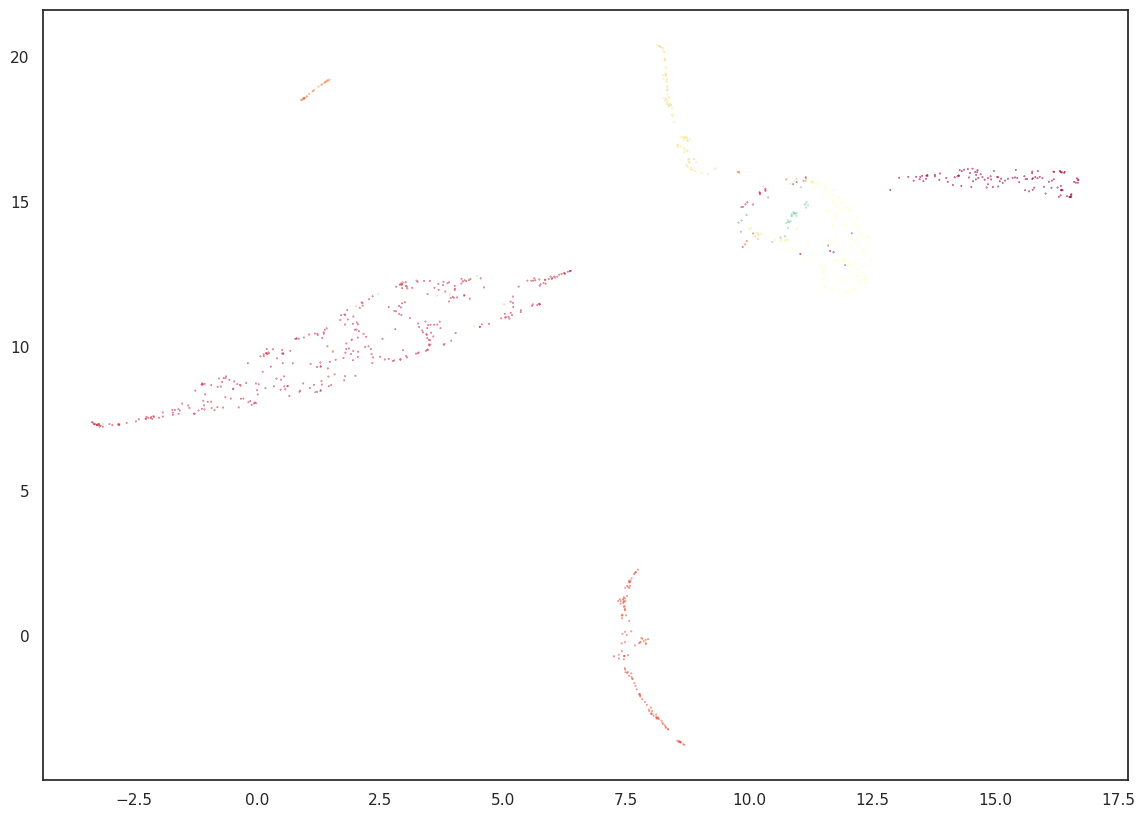

In [33]:
# Without preprocessing raw data
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype"], s=0.1, cmap='Spectral',);

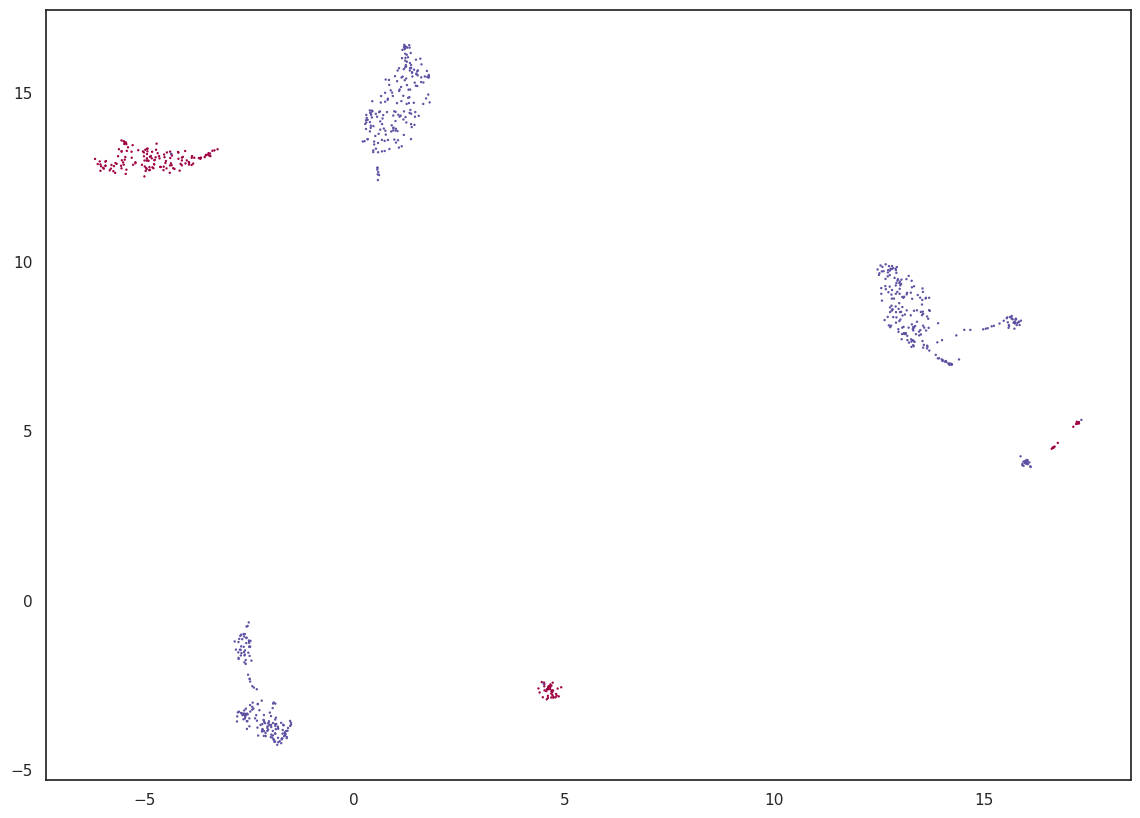

In [144]:
# Try on test data
sc_test_pp = sc_preprocess(sc_test, 700)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_test["Disease"], s=0.5, cmap='Spectral');

## 2. Clustering - PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

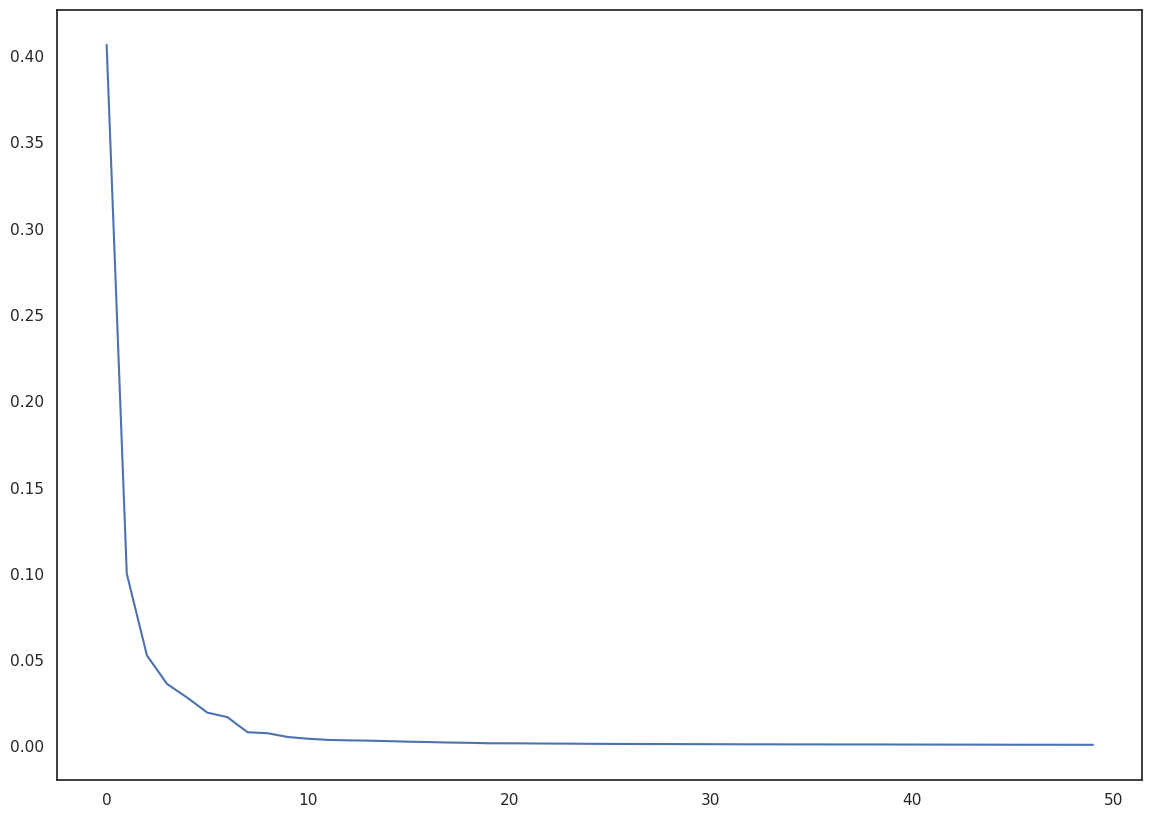

In [131]:
# compute PCA on training data
pca = PCA(n_components=50)
sc_train_pp = sc_preprocess(sc_train, 200)
pca.fit(sc_train_pp.T)

# plot explained variance
plt.plot(pca.explained_variance_ratio_)

# Store PCA components in correct format
pca_df = pd.DataFrame(pca.components_.T, columns=["PC"+str(i) for i in range(1,51)])
pca_df.insert(0, "index", sc_train_pp.index)
pca_df.to_csv("ML4G_Project_2_Data/pca/PCA_train.csv",index=True)

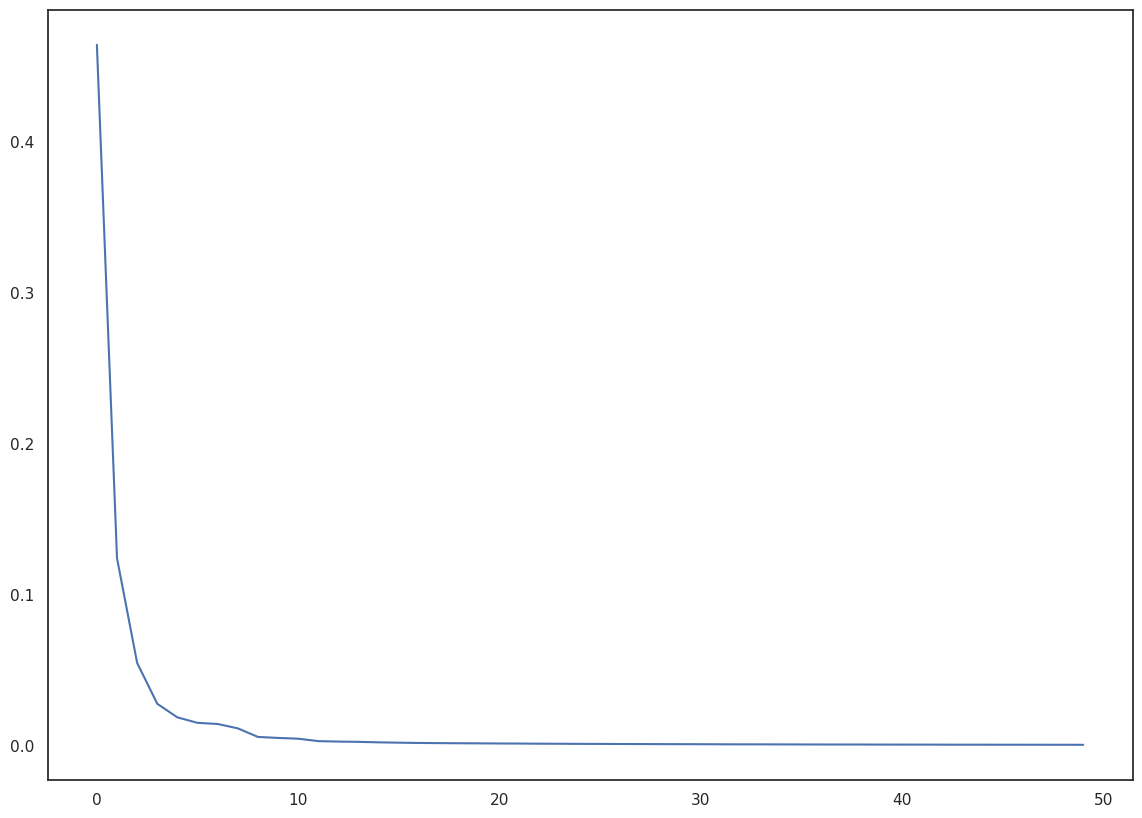

In [137]:
# compute PCA on test data
pca = PCA(n_components=50)
sc_test_pp = sc_preprocess(sc_test, 200)
pca.fit(sc_test_pp.T)

# plot explained variance
plt.plot(pca.explained_variance_ratio_)

# Store PCA components in correct format
pca_df = pd.DataFrame(pca.components_.T, columns=["PC"+str(i) for i in range(1,51)])
pca_df.insert(0, "index", sc_test_pp.index)
pca_df.to_csv("ML4G_Project_2_Data/pca/PCA.csv",index=True)

## 2. Clustering - Clustering

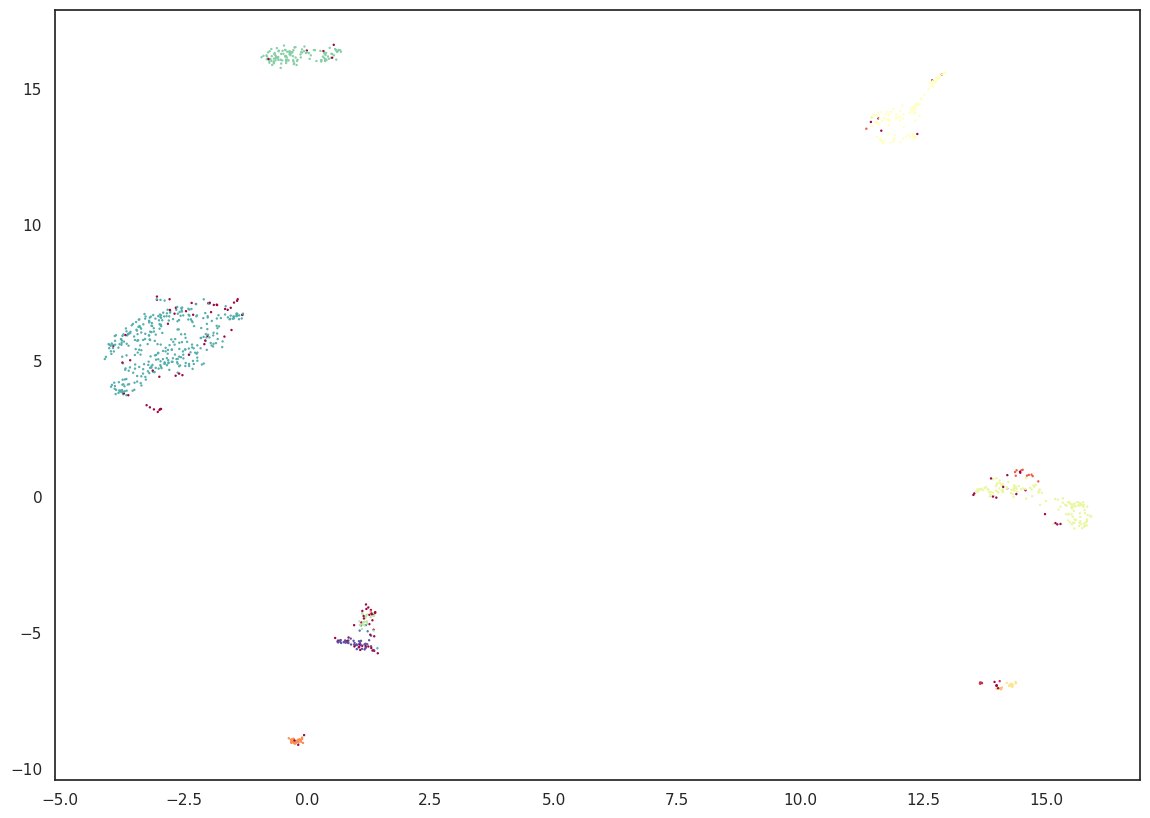

In [184]:
# perform analysis on training data
sc_train_pp = sc_preprocess(sc_train, 200)
lowd_sc_train = PCA(n_components=50).fit_transform(sc_train_pp)
hdbscan_labels = hdbscan.HDBSCAN().fit_predict(lowd_sc_train)
hdbscan_labels = pd.DataFrame(hdbscan_labels, index=sc_train_pp.index, columns=["HDBSCAN"])

# Look at results
sc_train_pp = sc_preprocess(sc_train, 200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=hdbscan_labels["HDBSCAN"], s=0.5, cmap='Spectral');

<Axes: >

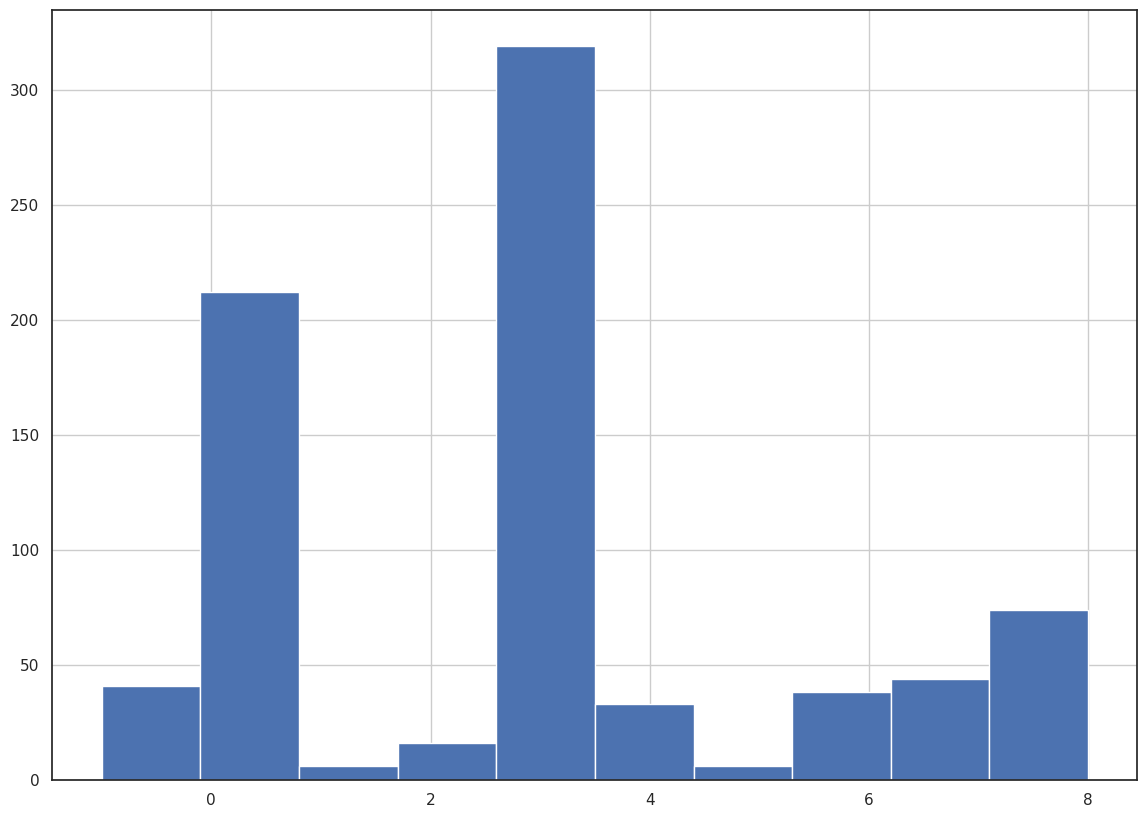

In [188]:
hdbscan_labels["HDBSCAN"].hist()

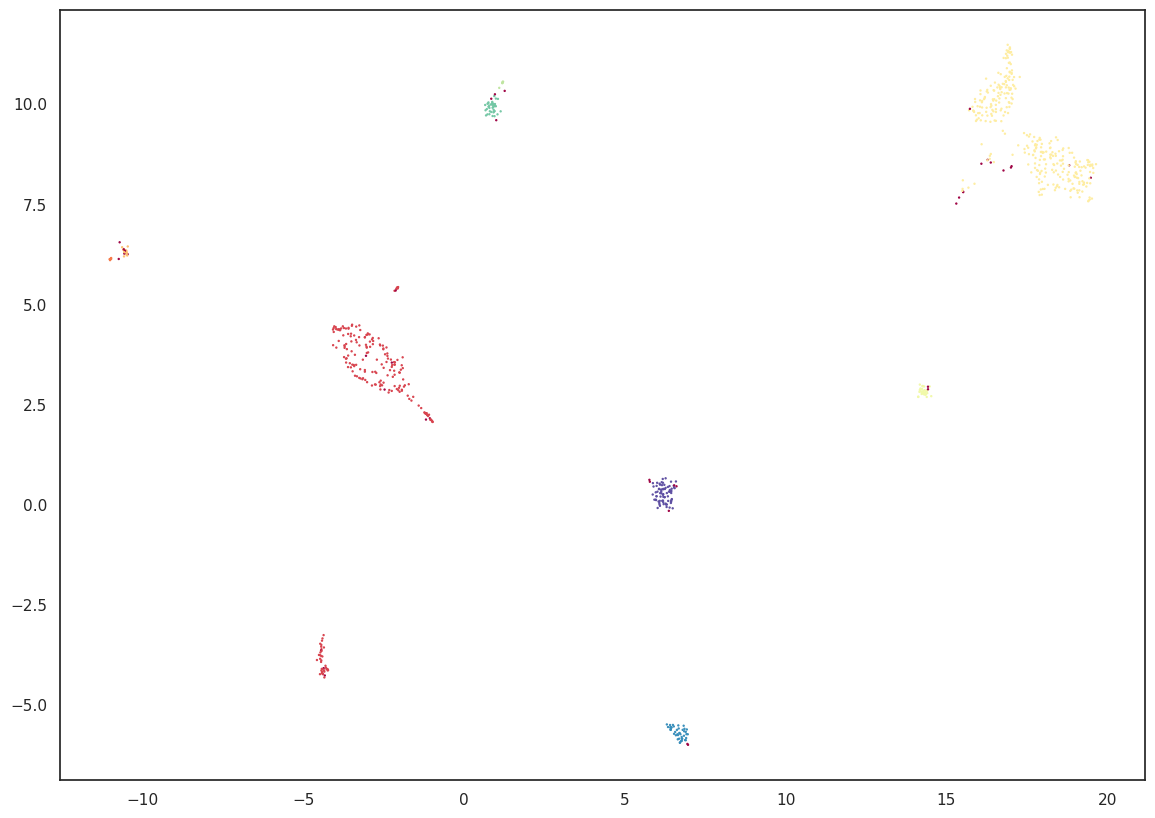

In [187]:
# perform analysis on training data
sc_test_pp = sc_preprocess(sc_test, 200)
lowd_sc_train = PCA(n_components=50).fit_transform(sc_test_pp)
hdbscan_labels = hdbscan.HDBSCAN().fit_predict(lowd_sc_train)
hdbscan_labels = pd.DataFrame(hdbscan_labels, index=sc_test_pp.index, columns=["HDBSCAN"])

# Look at results
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=hdbscan_labels["HDBSCAN"], s=0.5, cmap='Spectral');